In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import cv2
import math
import scipy.io as sio
import tensorflow as tf
import time
from time import ctime
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"

In [2]:
# pip install tensorflow-addons

In [3]:
# Check GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
# tf.config.experimental.set_memory_growth(physical_devices[2], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv3D,
                                     MaxPooling3D,ZeroPadding3D,SpatialDropout3D)
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras import regularizers

In [5]:
with open('./list/c3d_train002.txt', 'r') as f:
# with open('./list/c3d_train001.txt', 'r') as f:
# with open('./list/c3d_train01.txt', 'r') as f:
# with open('./list/c3d_train01-Copy1.txt', 'r') as f:
        lines = f.read().split('\n')
    
tr_files = [line for line in lines if len(line) > 0]
tr_files = shuffle(tr_files)

In [6]:
X_trainDataset = []
Y_trainDataset = []
FRAMES = 16
for idx, tr_file in enumerate(tr_files):
    # print(tr_file.split(' '))
    path, frm, cls = tr_file.split(' ')
 
#     A = [0,0,0,0,0,0,1,2,3,4,5,6,7,8,9,10]
#     B = [int(frm)-11, int(frm)-10, int(frm)-9, int(frm)-8, int(frm)-7, int(frm)-6, int(frm)-5, int(frm)-4, int(frm)-3, int(frm)-2,  
#          int(frm)-1, int(frm)-1, int(frm)-1, int(frm)-1, int(frm)-1, int(frm)-1]    
#     X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in A])
#     Y_trainDataset.append(cls)
#     X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in B])
#     Y_trainDataset.append(cls)

    X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range(0, 0 + FRAMES)])
    Y_trainDataset.append(cls)
    
#     X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range((int(frm)//2) - 8, (int(frm)//2) + 8)])
#     Y_trainDataset.append(cls)

    if int(frm) < 32:
        X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range((int(frm)//2) - 8, (int(frm)//2) + 8)])
        Y_trainDataset.append(cls)
    elif int(frm) >= 32:
        X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range((int(frm)//2) - 16, (int(frm)//2) + 16, 2)])
        Y_trainDataset.append(cls)

    X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range(int(frm)-FRAMES - 0, int(frm) - 0)])
    Y_trainDataset.append(cls)

In [7]:
import random
XX = []
YY = []
for i in range(6000):
    temp = []
    for j in range(4):
        a = random.randint(0,5999)  
        af = tr_files[a]
        path, frm, cls = af.split(' ')
        aa = random.randint(0,int(frm)-5)
        temp += [ path + 'frm_%06d.jpg' % (f + 1) for f in range(aa, aa + 4)]
    XX.append(shuffle(temp))
    YY.append(str(6))
    
print(np.array(XX).shape)
print(np.array(YY).shape)

(6000, 16)
(6000,)


In [8]:
print(np.array(X_trainDataset).shape)
print(np.array(Y_trainDataset).shape)

(36036, 16)
(36036,)


In [9]:
X_trainDataset += XX
Y_trainDataset += YY

In [10]:
print(len(X_trainDataset))
print(len(Y_trainDataset))

42036
42036


In [11]:
from tqdm import tqdm
idx = 0
rf = []
ud = []
rfb = []
udb = []
def rescale_img(data_list):
    global idx
    st = time.time()
    realDataset = []
    for i in tqdm(data_list):
        cubedata = []
        # print(type(i))
        for j in i:
#             print(j)
            img = cv2.imread(j)[:, :, ::-1]
            height, width = 128, 171
            scale = 136
            img = cv2.resize(img, (width, height), interpolation = cv2.INTER_LINEAR)
            off_h = abs(np.ceil((height - scale) / 2).astype(int))
            off_w = abs(np.ceil((width - scale) / 2).astype(int))
            img = img[off_h:off_h + scale, off_w:off_w + scale, :]
            img = cv2.resize(img, (112, 112), interpolation = cv2.INTER_LINEAR)
            
            ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
            channels = cv2.split(ycrcb)
            cv2.equalizeHist(channels[0],channels[0])
            cv2.merge(channels,ycrcb)
            img = cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR)
            
            edge = cv2.Laplacian(img, cv2.CV_64F)
            edge_x = cv2.Sobel(img, cv2.CV_16S, 1,0)
            edge_y = cv2.Sobel(img, cv2.CV_16S, 0,1)
            sharp = img -0.7 * edge+ 0.15* edge_x + 0.15* edge_y
            sharp[sharp > 255] = 255
            sharp[sharp < 0] = 0
            SHARP = sharp.astype('uint8')            

                    
            cubedata.append(SHARP)
            # cubedata.append(img)
        
        # Random flip
        is_flip_rf = np.random.rand(1, 1).squeeze() > 0.5
        rfb.append(is_flip_rf)
        
        is_flip_ud = np.random.rand(1, 1).squeeze() > 0.5
        udb.append(is_flip_ud)
        
        if is_flip_rf and not(is_flip_ud):
            voxel = np.flip(cubedata, axis=2)
            rf.append(idx)
        elif not(is_flip_rf) and is_flip_ud:
            voxel = np.flip(cubedata, axis=1)
            ud.append(idx)
        elif not(is_flip_rf) and not(is_flip_ud):
            voxel = cubedata.copy()
        elif is_flip_rf and is_flip_ud:
            voxel = cubedata.copy()
            
        realDataset.append(voxel)
        idx+=1
                
#         realDataset.append(cubedata)
    et = time.time()
    print((et-st)/60)
    # return np.array(realDataset).astype('float32')/1.
    return np.array(realDataset)

In [12]:
X = rescale_img(X_trainDataset)

100%|██████████| 42036/42036 [25:50<00:00, 27.11it/s]  


25.84029664993286


In [13]:
# np.save('./train_dataset_img', X)

In [14]:
X.shape

(42036, 16, 112, 112, 3)

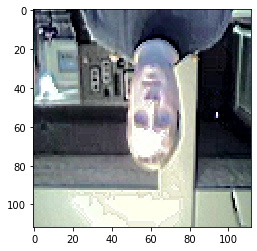

In [15]:
plt.imshow(X[2][7])
plt.show()

In [16]:
flip_i = 0
for k,v in enumerate(rfb):
    if v and not(udb[k]):
#         print(k,v,udb[k])
        flip_i+=1
    elif not(v) and udb[k]:
#         print(k,v,udb[k])
        flip_i+=1
# for k,v in enumerate(ud):
#     if v:
#         print(k)   
print(flip_i)
print(len(rf))
print(len(ud))

21031
10515
10516


In [17]:
# change class mapping
rf_map = {'0':'1','1':'0','2':'2','3':'3','4':'5','5':'4','6':'6'}

ud_map = {'0':'0','1':'1','2':'3','3':'2','4':'4','5':'5','6':'6'}

for vrf in rf:
#     print(Y_trainDataset[vrf])
    Y_trainDataset[vrf] = rf_map[str(Y_trainDataset[vrf])]
#     print(Y_trainDataset[vrf])
for vud in ud:
#     print(Y_trainDataset[vud])
    Y_trainDataset[vud] = ud_map[str(Y_trainDataset[vud])]
#     print(Y_trainDataset[vud])


In [18]:
y = np.array(Y_trainDataset)
Y = to_categorical(y,)
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [19]:
Y.shape

(42036, 7)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train, x_test, y_train, y_test= train_test_split(X,Y,test_size=0.2, random_state=42)

In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33628, 16, 112, 112, 3)
(8408, 16, 112, 112, 3)
(33628, 7)
(8408, 7)


In [23]:
# def C3DNN_Gesture(training):
# 20201011 add dense layer regularizers
# 20201011 add conv3D SpatialDropout3D(0.25)
def C3DNN_Gesture():
    inputs = Input(shape=(16, 112, 112, 3))
    x = inputs - tf.constant([96.6], dtype=tf.float32, shape=[1, 1, 1, 1, 1])
    x = Conv3D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(x)
    
    x = Conv3D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = Conv3D(256, 3, padding='same', activation='relu')(x)
    ########################################################
    x = SpatialDropout3D(0.25)(x)
    ########################################################
    x = Conv3D(256, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = Conv3D(512, 3, padding='same', activation='relu')(x)
    ########################################################
    x = SpatialDropout3D(0.25)(x)
    ########################################################
    x = Conv3D(512, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = ZeroPadding3D(padding=((1,1), (1,1), (1,1)),)(x)
       
    x = Conv3D(512, 3, padding='valid', activation='relu')(x)
    x = ZeroPadding3D(padding=((1,1), (1,1), (1,1)),)(x)
    
    x = Conv3D(512, 3, padding='valid', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(4096, activation='relu',
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5))(x)

    x = Dropout(rate=0.5,seed=None)(x)
    
    x = Dense(4096, activation='relu',
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5))(x)

    x = Dropout(rate=0.5,seed=None)(x)
    
    outputs = Dense(7, activation='softmax', kernel_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.001), bias_initializer = keras.initializers.Zeros())(x)
#     outputs = Dense(6, activation='softmax', kernel_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.001), bias_initializer = keras.initializers.Zeros())(x)
    return Model(inputs ,outputs)
    

In [24]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [25]:
BATCH_SIZE_PER_REPLICA = 16
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [26]:
weights = sio.loadmat('./pretrained/c3d_sports1m_tf.mat', squeeze_me=True)['weights']
Weights = weights.tolist()
len(Weights)

22

In [27]:
learning_rate = 0.001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

Optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

epochs = 30

In [28]:
with strategy.scope():
    model = C3DNN_Gesture()

    init_weight = model.get_weights()
    last_one = init_weight[21]
    last_two = init_weight[20]
    
    load_Weight = Weights[0:20]
    load_Weight.append(last_two)
    load_Weight.append(last_one)
    load_weight = np.array(load_Weight)
    model.set_weights(load_weight)

    model.compile(loss = 'categorical_crossentropy', optimizer = Optimizer, metrics = ['accuracy'])
    

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [29]:
model_dir = './Model/model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
times = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

logfiles = model_dir + '/{}'.format('basic_model')

model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                            histogram_freq=1)

modelfiles = model_dir + '/{}-best-model-{}.h5'.format('basic_model',times)
# modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

callbacks_list = [model_cbk, model_mckp]

In [30]:
print(ctime())
history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(x_test, y_test), shuffle=True, callbacks=callbacks_list)
print(ctime())

Tue Oct 27 07:21:28 2020
Train on 33628 samples, validate on 8408 samples
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/

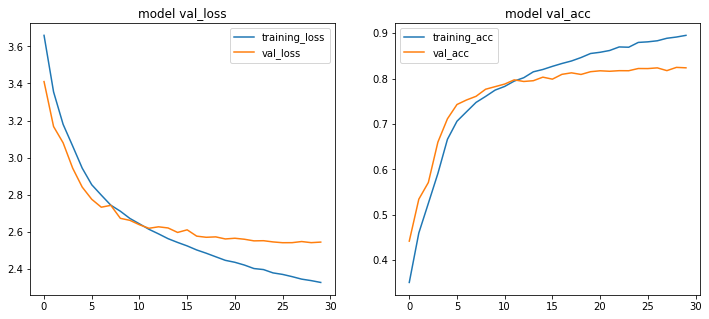

In [31]:
import time
TIME = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)

plt.savefig(f'acc_val_K3DCNN_{TIME}.png')
plt.show()

In [32]:
# ========================================================================================================= #

In [33]:
model.save(f'./Model/model-logs/basic_model-best-model-{times}-v2.h5')

In [ ]:
# ========================================================================================================= #

In [31]:
# load val data and 

In [20]:
# with open('./list/c3d_test005.txt', 'r') as f:
with open('./list/c3d_val001.txt', 'r') as f:
# with open('./list/c3d_val02.txt', 'r') as f:
        lines = f.read().split('\n')
val_files = [line for line in lines if len(line) > 0]
val_files = shuffle(val_files)

In [21]:
len(val_files)

6000

In [22]:
# put 16 frmae of every validate folder into list
X_validateDataset = []
Y_validateDataset = []
FRAMES = 16
for idx, val_file in enumerate(val_files):
    path, st, cls, frm = val_file.split(' ')
    X_validateDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range((int(frm)//2)-8, (int(frm)//2)+8)])
    Y_validateDataset.append(cls)
    

In [23]:
# X_validateDataset[0:3]
# Y_validateDataset[0:3]
len(X_validateDataset)

6000

In [24]:
from tqdm import tqdm
import time
def validate_rescale_img(data_list):
    ST = time.time()
    realDataset = []
    for i in tqdm(data_list):
        cubedata = []
        # print(type(i))
        for j in i:
            # print(j)
            img = cv2.imread(j)[:, :, ::-1]
            height, width = 128, 171
            scale = 136
            img = cv2.resize(img, (width, height), interpolation = cv2.INTER_LINEAR)
            off_h = abs(np.ceil((height - scale) / 2).astype(int))
            off_w = abs(np.ceil((width - scale) / 2).astype(int))
            img = img[off_h:off_h + scale, off_w:off_w + scale, :]
            img = cv2.resize(img, (112, 112), interpolation = cv2.INTER_LINEAR)            

            cubedata.append(img)

        realDataset.append(cubedata)
    ET = time.time()
    print((ET-ST)/60)
    return np.array(realDataset)

In [25]:
X_val = validate_rescale_img(X_validateDataset)

100%|██████████| 6000/6000 [02:23<00:00, 41.86it/s]


2.3890079577763874


In [26]:
X_val.shape

(6000, 16, 112, 112, 3)

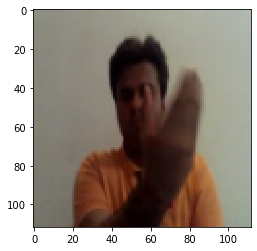

In [27]:
plt.imshow(X_val[0][10])
plt.show()

In [28]:
y_val = np.array(Y_validateDataset)
Y_val = to_categorical(y_val,7)

In [29]:
print(X_val.shape)
print(Y_val.shape)

(6000, 16, 112, 112, 3)
(6000, 7)


In [30]:
from tensorflow.keras.models import load_model

In [35]:
new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-27_07-21-28.h5') 
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-27_07-21-28-v2.h5') 

# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-25_09-31-51.h5') 
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-24_21-50-57.h5') 

# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-11_16-41-12.h5') 
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-18_00-57-57.h5') #0.86
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-15_17-17-52.h5')
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-12_20-28-06.h5') #0.92
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-09_20-11-11.h5') #0.89

In [36]:
val_loss,val_accuracy = new_model.evaluate(X_val,Y_val)

6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [2]:
# from tensorflow.keras.models import load_model

In [3]:
# new_model = load_model('./Model/model-logs/basic_model-best-model.h5')

In [5]:
# new_model.summary()

In [ ]:
# y_pred = new_model.predict(std_X_test)

In [ ]:
# y_label = np.argmax(y_pred, axis=1)